In [1]:
import glob
import os
from pathlib import Path
import pickle
import time

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.io as sio

from nils.reconstruction_module import cleanup_formfactor, master_recon
from nils.simulate_spectrometer_signal import get_crisp_signal
import spectralvd

In [2]:
def current2formfactor(s, current, grating="both"):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set=grating)
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor


data_files = ["rf_train", "formfactors_train", "peaks_train", "currents_train", "rf_test", "formfactors_test", "peaks_test", "currents_test"]
if all(os.path.isfile(f"data/peak_{f}.pkl") for f in data_files):
    print("Loading data")
    rf_train, formfactors_train, peaks_train, currents_train, rf_test, formfactors_test, peaks_test, currents_test = [spectralvd.from_pickle(f"data/{f}") for f in data_files]
else:
    print("Generating data")
    with open("ocelot80k.pkl", "rb") as file:
        data = pickle.load(file)
       
    currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
       
    rfparam_keys = ["chirp", "curv", "skew", "l1", "l2", "A1.v", "A1.phi", "AH1.v", "AH1.phi", "L1.v",
                    "L1.phi", "L2.v", "L2.phi"]
    # rfparam_keys = ["A1.v", "A1.phi", "AH1.v", "AH1.phi", "L1.v", "L1.phi", "L2.v", "L2.phi"]
    rfparams = [[sample[k] for k in rfparam_keys] for sample in data]
       
    del data
    
    filtered_currents = [(s, current) for s, current in currents if current.max() > 1000]
    filtered_rfparams = [sample for sample, (_, current) in zip(rfparams, currents) if current.max() > 1000]

    formfactors = np.array([current2formfactor(*current, grating="both") for current in filtered_currents])
    
    X = list(zip(filtered_rfparams, formfactors))
    y = filtered_currents
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
       
    rf_train = [rf for rf, _ in X_train]
    formfactors_train = [ff for _, ff in X_train]
    peaks_train = [current.max() for _, current in y_train]
    currents_train = y_train
    rf_test = [rf for rf, _ in X_test]
    formfactors_test = [ff for _, ff in X_test]
    peaks_test = [current.max() for _, current in y_test]
    currents_test = y_test
    
    Path("data").mkdir(parents=True, exist_ok=True)
    datas = [rf_train, formfactors_train, peaks_train, currents_train, rf_test, formfactors_test, peaks_test, currents_test]
    for f, d in zip(data_files, datas):
       spectralvd.to_pickle(d, f"data/peak_{f}")

Loading data


In [3]:
hardrf_train = np.array(rf_train)[:,5:]
hardrf_test = np.array(rf_test)[:,5:]

# hardrf_disturbed_train = rf_train_disturbed[:,5:]
# hardrf_disturbed_test = rf_test_disturbed[:,5:]

# max_hardrfs = max_rfs[5:]

### Train different models

In [4]:
model_dir = "models"

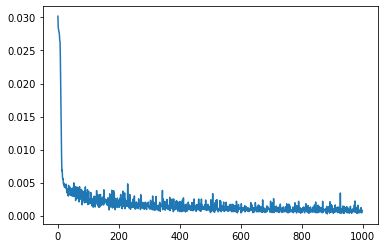

In [5]:
path = f"{model_dir}/peakannrf"
if os.path.isdir(path):
    annrf = spectralvd.PeakANNRF.load(path)
else:
    annrf = spectralvd.PeakANNRF()
    annrf.fit(hardrf_train, peaks_train, epochs=1000, verbose=0)
    annrf.save(path)

plt.plot(annrf.history["loss"])
plt.show()

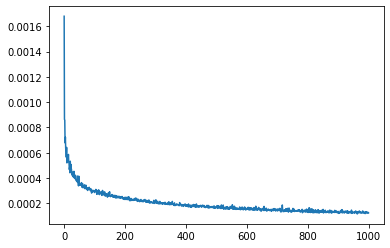

In [6]:
path = f"{model_dir}/peakannthz"
if os.path.isdir(path):
    annthz = spectralvd.PeakANNTHz.load(path)
else:
    annthz = spectralvd.PeakANNTHz()
    annthz.fit(formfactors_train, peaks_train, epochs=1000, verbose=0)
    annthz.save(path)

plt.plot(annthz.history["loss"])
plt.show()

INFO:tensorflow:Assets written to: models/peakannrfthz/model/assets


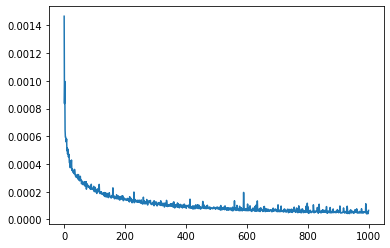

In [9]:
path = f"{model_dir}/peakannrfthz"
if os.path.isdir(path):
    annrfthz = spectralvd.PeakANNRFTHz.load(path)
else:
    annrfthz = spectralvd.PeakANNRFTHz()
    annrfthz.fit(hardrf_train, formfactors_train, peaks_train, epochs=1000, verbose=0)
    annrfthz.save(path)

plt.plot(annrfthz.history["loss"])
plt.show()

In [11]:
path = f"{model_dir}/peakknnrf"
if os.path.isdir(path):
    knnrf = spectralvd.PeakKNNRF.load(path)
else:
    knnrf = spectralvd.PeakKNNRF()
    knnrf.fit(hardrf_train, peaks_train)
    knnrf.save(path)

In [12]:
path = f"{model_dir}/peakknnthz"
if os.path.isdir(path):
    knnthz = spectralvd.PeakKNNTHz.load(path)
else:
    knnthz = spectralvd.PeakKNNTHz()
    knnthz.fit(formfactors_train, peaks_train)
    knnthz.save(path)

In [13]:
path = f"{model_dir}/peakknnrfthz"
if os.path.isdir(path):
    knnrfthz = spectralvd.PeakKNNRFTHz.load(path)
else:
    knnrfthz = spectralvd.PeakKNNRFTHz()
    knnrfthz.fit(hardrf_train, formfactors_train, peaks_train)
    knnrfthz.save(path)

### Example Predictions

In [14]:
fullcurrent = spectralvd.AdaptiveANNRFTHz.load(f"models/annrfthz")

### MAE

In [15]:
model_maes = {}

predictions = annrf.predict(hardrf_test).squeeze()
truths = np.array(peaks_test).squeeze()
model_maes["ANN RF"] = np.abs(truths - predictions).mean()

predictions = annthz.predict(formfactors_test).squeeze()
truths = np.array(peaks_test).squeeze()
model_maes["ANN CRISP"] = np.abs(truths - predictions).mean()

predictions = annrfthz.predict(hardrf_test, formfactors_test).squeeze()
truths = np.array(peaks_test).squeeze()
model_maes["ANN RF + CRISP"] = np.abs(truths - predictions).mean()

predictions = knnrf.predict(hardrf_test).squeeze()
truths = np.array(peaks_test).squeeze()
model_maes["KNN RF"] = np.abs(truths - predictions).mean()

predictions = knnthz.predict(formfactors_test).squeeze()
truths = np.array(peaks_test).squeeze()
model_maes["KNN CRISP"] = np.abs(truths - predictions).mean()

predictions = knnrfthz.predict(hardrf_test, formfactors_test).squeeze()
truths = np.array(peaks_test).squeeze()
model_maes["KNN RF + CRISP"] = np.abs(truths - predictions).mean()

predictions = []
for current in currents_test:
    frequencies, formfactors, formfactor_noise, detlim = get_crisp_signal(current[0], current[1], n_shots=10, which_set="both")
    recon_time, recon_current, t_rms = master_recon(frequencies, formfactors, formfactor_noise, detlim, charge=250e-12,
                                                    method="KKstart", channels_to_remove=[], show_plots=False)
    
    predictions.append(recon_current.max())
predictions = np.array(predictions)
truths = np.array(peaks_test).squeeze()
model_maes["Reconstruction"] = np.abs(truths - predictions).mean()

/usr/local/Caskroom/miniconda/base/envs/spectral-vd/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [16]:
predictions = fullcurrent.predict(hardrf_test, formfactors_test)
prediction_maxs = predictions[:,1].max(axis=-1)
truths = np.array(peaks_test).squeeze()
model_maes["ANN CURRENT"] = np.abs(truths - prediction_maxs).mean()

In [17]:
model_maes

{'ANN RF': 625.247690155913,
 'ANN CRISP': 149.31506680674713,
 'ANN RF + CRISP': 109.17301151983958,
 'KNN RF': 1069.84613341226,
 'KNN CRISP': 137.58207476523395,
 'KNN RF + CRISP': 690.3906444103349,
 'Reconstruction': 391.5102712923935,
 'ANN CURRENT': 284.01786746104875}

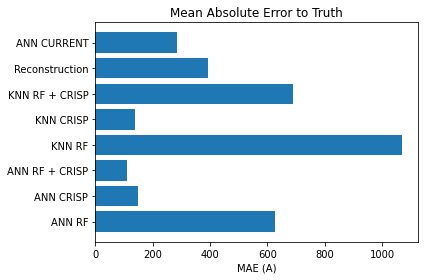

In [18]:
results = [(k, v) for k, v in model_maes.items()]
names = [k for k, _ in results]
values = [v for _, v in results]

plt.figure(figsize=(6,4))
plt.title("Mean Absolute Error to Truth")
plt.barh(names, values)
plt.xlabel("MAE (A)")
plt.tight_layout()
plt.show()

### Test on Real Data from Nils

In [29]:
l1s_real = []
formfactors_real = []
currents_real = []

tds_mat = sio.loadmat("for_jan/TDS/tds_l1_results.mat")
for l1, current in zip(tds_mat["l1"].astype("float64").squeeze(), tds_mat["currents"].astype("float64").squeeze()):
    paths = glob.glob(f"for_jan/CRISP/formfactor_new_*_*_*_l1_{l1:.1f}.mat")
    assert len(paths) == 1
    
    crisp_mat = sio.loadmat(paths[0])
    
    l1s_real.append(l1)
    formfactors_real.append((
        crisp_mat["frequencies"].astype("float64").squeeze(),
        crisp_mat["formfactors"].astype("float64").squeeze(),
        crisp_mat["formfactors_err"].astype("float64").squeeze(),
        crisp_mat["det_lim"].astype("float64").squeeze(),
        float(crisp_mat["charge"].astype("float64").squeeze())
    ))
    currents_real.append((tds_mat["time"].astype("float64").squeeze()*3e8, current))

In [30]:
formfactors_real_clean = [cleanup_formfactor(freq, ff, ff_noise, detlim, channels_to_remove=[])[:2] for freq, ff, ff_noise, detlim, _ in formfactors_real]

In [31]:
def reconstruct_by_nils(frequencies, formfactors, formfactor_noise, detlim, charge):
    recon_time, recon_current, t_rms = master_recon(frequencies, formfactors, formfactor_noise, detlim, charge=charge,
                                                    method="KKstart", channels_to_remove=[], show_plots=False)
    centered = center_currents([(recon_time * 3e8, recon_current)])
    return centered[0]

In [32]:
real_current_predictions_knn = knnthz.predict([(freq, ff) for freq, ff in formfactors_real_clean])
real_current_predictions_ann = annthz.predict([(freq, ff) for freq, ff in formfactors_real_clean])
real_current_predictions_nils = np.array([reconstruct_by_nils(*record) for record in formfactors_real])
real_current_predictions_lockmann = lockmann.predict(formfactors_real)
real_current_predictions = list(zip(
    real_current_predictions_knn,
    real_current_predictions_ann,
    real_current_predictions_nils,
    real_current_predictions_lockmann
))

In [33]:
currents_real_centered = center_currents(currents_real)

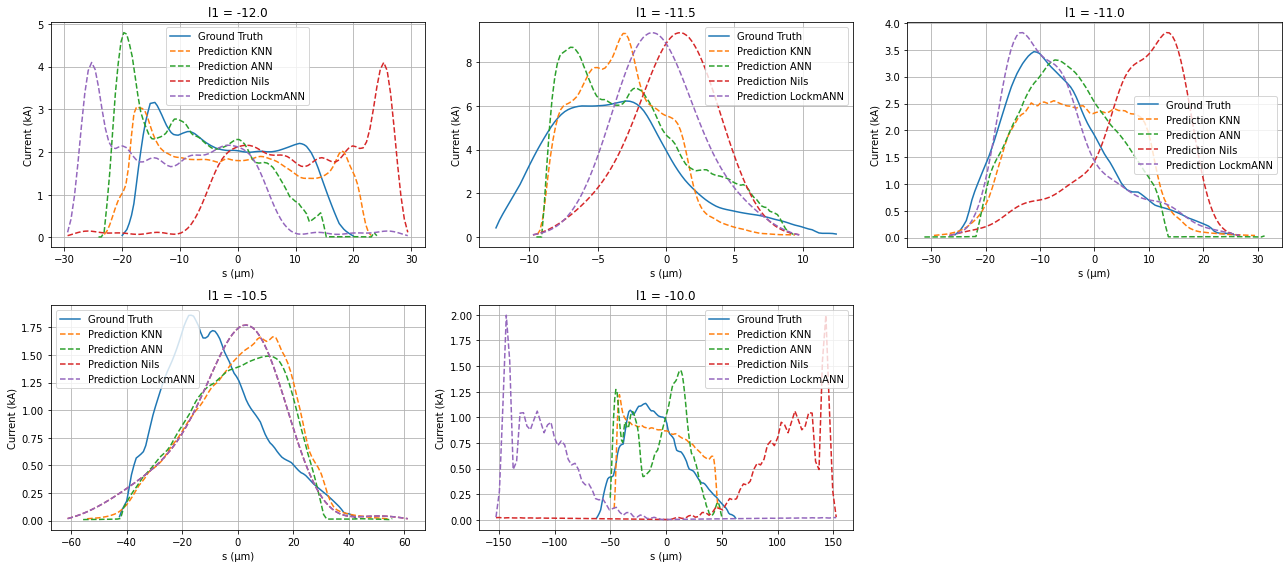

In [34]:
plt.figure(figsize=(18,8))
for i, (l1, truth, prediction) in enumerate(zip(l1s_real, currents_real_centered, real_current_predictions)):
    plt.subplot(2, 3, i+1)
    plt.title(f"l1 = {l1:.1f}")
    plot_prediction(truth, prediction, labels=["KNN","ANN","Nils","LockmANN"])
plt.tight_layout()
plt.show()

In [35]:
l2s_real = []
formfactors_real = []
currents_real = []

tds_mat = sio.loadmat("for_jan/TDS/tds_l2_results.mat")
for l2, current in zip(tds_mat["l2"].astype("float64").squeeze(), tds_mat["currents"].astype("float64").squeeze()):
    paths = glob.glob(f"for_jan/CRISP/formfactor_new_*_*_*_l2_{l2:.1f}.mat")
    assert len(paths) == 1
    
    crisp_mat = sio.loadmat(paths[0])
    
    l2s_real.append(l2)
    formfactors_real.append((
        crisp_mat["frequencies"].astype("float64").squeeze(),
        crisp_mat["formfactors"].astype("float64").squeeze(),
        crisp_mat["formfactors_err"].astype("float64").squeeze(),
        crisp_mat["det_lim"].astype("float64").squeeze(),
        float(crisp_mat["charge"].astype("float64").squeeze())
    ))
    currents_real.append((tds_mat["time"].astype("float64").squeeze()*3e8, current))

In [36]:
formfactors_real_clean = [cleanup_formfactor(freq, ff, ff_noise, detlim, channels_to_remove=[])[:2] for freq, ff, ff_noise, detlim, _ in formfactors_real]

In [37]:
real_current_predictions_knn = knnthz.predict([(freq, ff) for freq, ff in formfactors_real_clean])
real_current_predictions_ann = annthz.predict([(freq, ff) for freq, ff in formfactors_real_clean])
real_current_predictions_nils = np.array([reconstruct_by_nils(*record) for record in formfactors_real])
real_current_predictions_lockmann = lockmann.predict(formfactors_real)
real_current_predictions = list(zip(
    real_current_predictions_knn,
    real_current_predictions_ann,
    real_current_predictions_nils,
    real_current_predictions_lockmann
))

In [38]:
currents_real_centered = center_currents(currents_real)

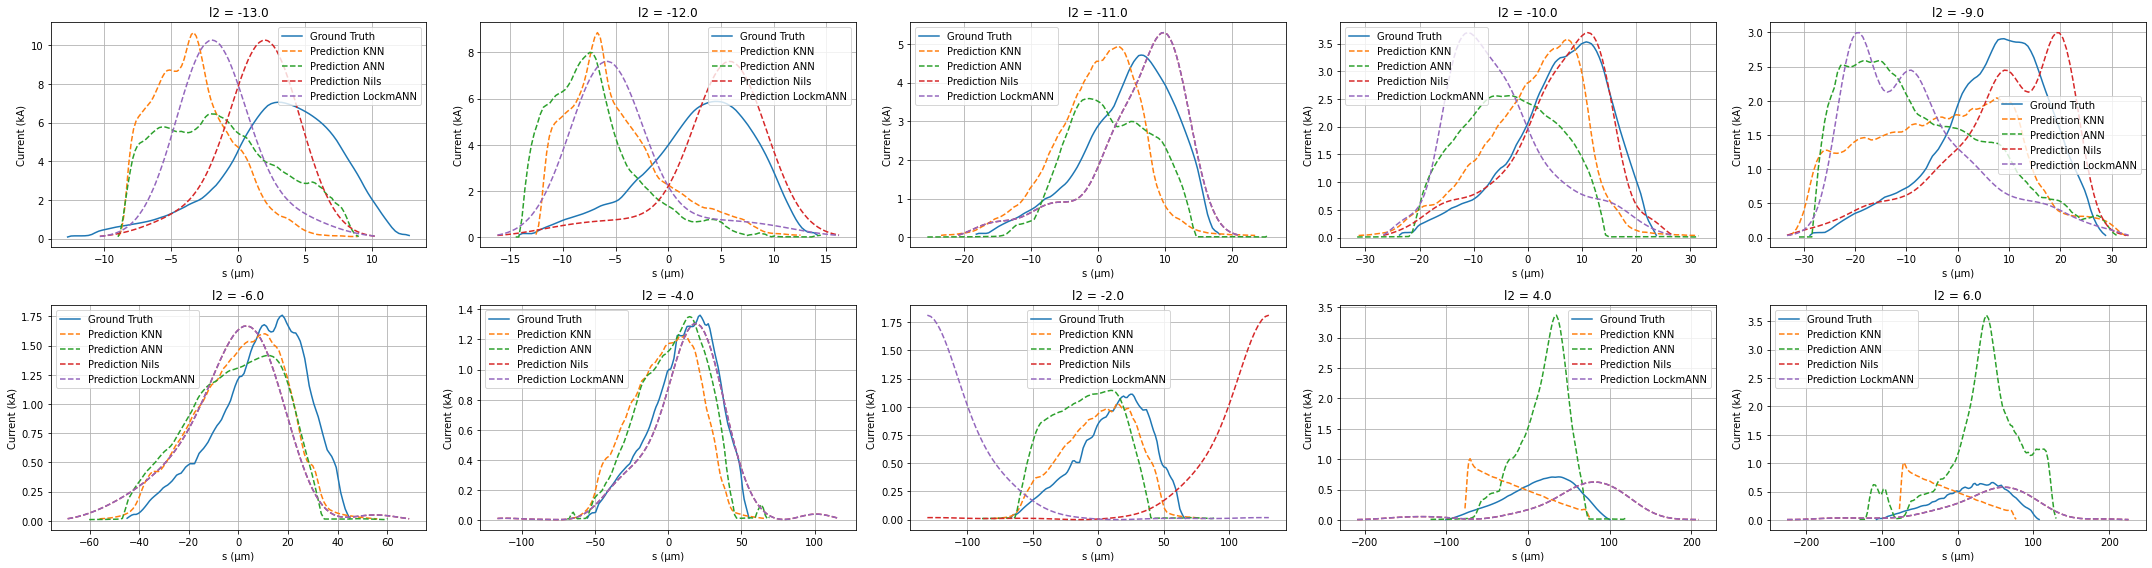

In [39]:
plt.figure(figsize=(30,8))
for i, (l2, truth, prediction) in enumerate(zip(l2s_real, currents_real_centered, real_current_predictions)):
    plt.subplot(2, 5, i+1)
    plt.title(f"l2 = {l2:.1f}")
    plot_prediction(truth, prediction, labels=["KNN","ANN","Nils","LockmANN"])
plt.tight_layout()
plt.show()

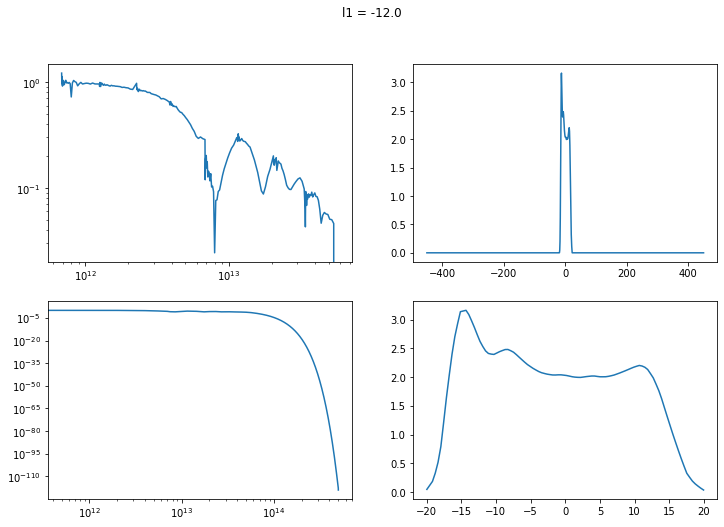

In [49]:
i = 0

plt.figure(figsize=(12,8))
plt.suptitle(f"l1 = {l1s_real[i]}")
plt.subplot(221)
plt.loglog(formfactors_real[0][0], formfactors_real[0][1])
plt.subplot(222)
plt.plot(currents_real[0][0]*1e6, currents_real[0][1]*1e-3)
plt.subplot(223)
plt.loglog(formfactors_real_clean[0][0], formfactors_real_clean[0][1])
plt.subplot(224)
plt.plot(currents_real_centered[0][0]*1e6, currents_real_centered[0][1]*1e-3)
plt.show()